# LSBG Tangential Shear Measurement Analysis

Low surface brightness galaxies (LSBGs) are diffuse galaxies with a surface brightness dimmer than the ambient night sky. Given their faintness, the use of traditional astronomical techniques for observation proves challenging. Weak gravitational lensing probes both the baryonic and dark matter content of these galaxies, rendering it a powerful technique to estimate LSBG masses. Weak gravitational lensing averages the shear, or distortion, of thousands of images of background galaxies to extract the distortion caused by the lens object. The large counts of lens-source pairs enable us to find a preferred tangential alignment of source galaxies around lens galaxies: the tangential shear. In this notebook, we analyze the LSBG tangential shear measurements obtained with [TreeCorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html). The LSBG catalog ([Tangolidis et al. 2020](https://arxiv.org/pdf/2006.04294.pdfLSBGs)) divides the LSBG sample into red galaxies at $g-i>0.6$ and blue galaxies at $g-i<0.6$. We plot the tangential shear measurements, perform a series of systematics tests to evaluate their robustness, survey the behavior of their covariance matrices, and explore an alternative set of color cuts.

## Imports

* We use numpy for numerical calculation and analysis
* We use matplotlib for plotting and visualization

In [1]:
#Loading packages
import matplotlib.pyplot as plt
import numpy as np
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Loading Data

### Red, Blue, and Total Tangential Shear Measurements 

We load the tangential shear measurements for the red, blue, and total LSBG sample. In addition, we load the tangential shear measurements conducted on the random point sample. 'theta' corresponds to the angular scales of the measurements, 'xi' marks the tangential shear, 'error' represents the shape noise, 'err_jk' indicates the jackknife covariance, and the 'cross term' stands for the shear measured around the lensing B-mode. 

In [2]:
#Loading in measurements
theta_red, xi_red, error_red, cross_term_red = np.loadtxt('../data/gt_LSBG_combined_sources_scales_4_red_ran', unpack=True)
theta_red, xi_red, err_jk_red, cross_term_red = np.loadtxt('../data/gt_LSBG_jackknife_combined_sources_scales_4_red_ran', unpack=True)

theta_blue, xi_blue, error_blue,  cross_term_blue = np.loadtxt('../data/gt_LSBG_combined_sources_scales_4_blue_ran', unpack=True)
theta_blue, xi_blue, err_jk_blue, cross_term_blue = np.loadtxt('../data/gt_LSBG_jackknife_combined_sources_scales_4_blue_ran', unpack=True)

theta, xi, error,  cross_term = np.loadtxt('../data/gt_LSBG_combined_sources_scales_4_ran', unpack=True)
theta, xi, err_jk, cross_term = np.loadtxt('../data/gt_LSBG_jackknife_combined_sources_scales_4_ran', unpack=True)

theta_randoms, xi_randoms, error_randoms, err_jk_randoms = np.loadtxt('../data/rg_gt_scales_4_ran', unpack=True)

theta_blue_alt, xi_blue_alt, error_blue_alt, cross_term_blue_alt = np.loadtxt('../data/gt_LSBG_combined_sources_scales_4_blue_alt_ran', unpack=True)
theta_blue_alt, xi_blue_alt, err_jk_blue_alt, cross_term_blue_alt = np.loadtxt('../data/gt_LSBG_jackknife_combined_sources_scales_4_blue_alt_ran', unpack=True)



### Covariance Matrices

We load the jackknife covariance matrices for the total, red, and blue LSBG samples. In addition, we load in the covariance matrices for the random sample and the $\gamma _\times$ term, or the lensing B-mode term.

In [3]:
#Loading in covariances
cov = np.loadtxt('jkcov_gt_LSBG_combined_sources_scales_4_ran')
cov_red = np.loadtxt('jkcov_gt_LSBG_combined_sources_scales_4_red_ran')
cov_blue = np.loadtxt('jkcov_gt_LSBG_combined_sources_scales_4_blue_ran')
randoms_cov = np.loadtxt('jkcov_randoms_ran_scales_4')
cross_term_cov = np.loadtxt('cov_xi_im_scales_4')
cross_term_cov_red = np.loadtxt('cov_xi_im_scales_4_red')
cross_term_cov_blue = np.loadtxt('cov_xi_im_scales_4_blue')


### Boost Factor Measurements

We load the boost factors, derived from the tangential shear measurements, and the boost factor covariance matrices. The boost factor measures the excess number of sources around lenses compared to the amount of sources around random points. We use the boost factor to quantify bias caused by lens-source clustering.

In [6]:
#Loading in boost factor
boost_factor = np.loadtxt('../data/boost_factor_scales_4')
boost_factor_red = np.loadtxt('../data/boost_factor_scales_4_red_recalibrated')
boost_factor_blue = np.loadtxt('../data/boost_factor_scales_4_blue_recalibrated')


In [7]:
#Loading boost factor covariances
boost_factor_cov = np.loadtxt('../data/boost_factor_covariance_scales_4')
boost_factor_red_cov = np.loadtxt('../data/boost_factor_covariance_scales_4_red_recalibrated')
boost_factor_blue_cov = np.loadtxt('../data/boost_factor_covariance_scales_4_blue_recalibrated')

## Function Definitions

### Measurement Quality Functions

We define the functions used to evaluate the strength of the measurements

We define two iterations of the $\chi^2$ statistic, used to determine the quality of the fit between a model and a dataset or between two models. We define the $\chi^2$ statistic as: $$\chi^2 = (\gamma_{t, d}-\gamma_{t,m})\times \mathrm{cov}^{-1}\times (\gamma_{t,d}-\gamma_{t,m}), $$ where $\gamma_{t,d}$ represents the measurements and $\gamma_{t,m}$ indicates the model. 

We calculate the $\chi^2_\mathrm{null}$ to assess the strength of the lensing signal. The $\chi^2_\mathrm{null}$ compares the lensing signal to a null model, as follows: $$\chi^2_\mathrm{null} = \gamma_{t,d}\times \mathrm{cov}^{-1}\times \gamma_{t, d}.$$ 


The $\chi^2$ statistic depends on the jackknife covariance, but the inverse of this matrix is biased and noisy. We correct for this bias by using the Hartlap factor ([Hartlap et al. 2007](https://arxiv.org/pdf/astro-ph/0608064.pdf)). The Hartlap factor scales the inverse of the covariance matrix by: $$f = (n-m-2)/(n-1),$$ with $n$ as the number of realizations (100, for our jackknife patches) and $m$ as the number of entries in the data vectors (22, for the number of angular bins). 

In [8]:
def hartlap(n=None, m=None):
    """
    Calculates the hartlap factor
    
    n = number of realizations (in our case 100)
    m = number of data entries (in our case 22)
    
    """
    hartlap_factor = (n - m -2)/ float(n-1)
    return hartlap_factor

In [9]:
def chi2(cov=None, model=None, measurements=None, n=None, m=None):
    """
    Calculates chi^2 between model and measurements
    
    cov = covariance matrix
    model = model of choice
    measurements = measurement of choice
    
    """
    invcov = (np.linalg.inv(cov))
    chi2_bias = np.dot((measurements-model), np.dot(invcov, (measurements-model)))
    hartlap_factor = hartlap(n=n, m=m)
    chi2 = chi2_bias*hartlap_factor
    return chi2

In [10]:
def chi2_null(cov=None, measurements=None, n=None, m=None):
    """
    Calculates chi^2 between measurements and null signal to evaluate signal strength
    
    cov = covariance matrix
    measurements = measurements
    
    """
    invcov = (np.linalg.inv(cov))
    chi2_bias = np.dot(np.dot((measurements), invcov), (measurements.T))
    hartlap_factor = hartlap(n=n, m=m)
    chi2 = chi2_bias*hartlap_factor
    return chi2

In [11]:
def deltachi2(cov=None, model_1=None, model_2=None, n=None, m=None):
    """
    Calculates the delta chi^2, the quantifiable difference between two models
    
    cov = jackknife covariance matrix
    model1 = first model
    model2 = second model
    n = number of realizations 
    m = number of data entries
    
    Returns: delta chi^2
    """
    invcov = np.linalg.inv(cov)
    INVCOV = np.matrix(invcov)
    diff = np.matrix((model_1).T[0]-(model_2).T[0])
    deltachi2_bias = diff*INVCOV*diff.T
    hartlap_factor = hartlap(n=n, m=m)
    deltachi2 = deltachi2_bias*hartlap_factor
    
    return deltachi2

We define a function to calculate the signal-to-noise (S/N) of the measurements, incorporating the $\chi^2_\mathrm{null}$, the hartlap factor, and the number of degrees of freedom $(\nu)$. The S/N values are defined as: $$\mathrm{S/N} = \sqrt{(\chi^2_\mathrm{null}*f) - \nu}. $$

In [12]:
def sn(dof=None, cov=None, measurements=None, n=None, m=None):
    """
    Calculates the signal-to-noise
    
    dof = number of degrees of freedom (in our case 25)
    cov = covariance matrix
    measurements = measurements
    n=number of realizations
    m = number of data entries
    
    """
    chi2 = chi2_null(cov=cov, measurements=measurements, n=n, m=m)
    sn = np.sqrt(chi2-dof)
    return sn

We define a function that constructs the correlation matrix for a given covariance.

In [13]:
def corrmatrix(cov=None):
    """
    Calculates the correlation matrix
    
    cov=covariance matrix
    
    """
    cov = np.mat(cov)
    D = np.diag(np.sqrt(np.diag(cov)))
    d = np.linalg.inv(D)
    corr = d*cov*d
    return corr

We define a function to calculate errorbars based on the jackknife covariance (if errorbars have not been provided by [TreeCorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html)). 

In [14]:
def errorbar(cov=None):
    """
    Calculates the errorbars based on the jackknife covariance
    
    cov = jackknife covariance matrix
    
    """
    err_jk = np.sqrt(np.diag(cov))
    return err_jk

### Visualization Functions

We define functions to plot the tangential shear measurements, the $\gamma_{\times}$ term, the random sample shear measurements, the covariance diagonals, and the covariance correlation matrices. 

We define a function that plots the tangential shear measurements (xi) across angular scales of 0.25-400 arcmin (theta) in 22 angular bins. The errorbars are derived from the jackknife covariance. 

In [15]:
def plot_tangential_shear(theta=None, xi=None, err_jk=None, color=None, galaxy_type=None):
    """
    Plots the tangential shear measurements across angular scales
    
    theta = angular scales
    xi = tangential shear signal 
    err_jk = jackknife errorbars
    color = color of plot (should match galaxy type, black for total)
    galaxy type = color type of galaxy (red, blue, or total)
    
    """
    fig = plt.figure(figsize=(5,3.5))
    for i in range(len(theta)):
        if xi[i]>0:
            plt.errorbar(theta, xi, err_jk, fmt="o", color=color)
        if xi[i]<=0:
            plt.errorbar(theta, -1*xi, err_jk, fmt="v", color=color)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("$\\theta$ [arcmin]")
    plt.ylabel("$\gamma_t(\\theta)$")
    plt.ylim(10**(-6),  3*10**(-2))
    plt.legend(frameon=False)
    plt.show()

We define functions that plot the shear measurement of the $\gamma_{\times}$ term and the shear measurement of the randoms sample. 

The tangential shear measures the distortion of the lensing E-mode, while the $\gamma_{\times}$ term measures the distortion of the lensing E-mode. Weak lensing only produces a tangential shear, thus in the absence of additional systematics the $\gamma_{\times}$ term should remain consistent with zero. 

The function calculates the errorbars for the $\gamma_{\times}$ (cross_term) based on the measured $\gamma_{\times}$ covariance (cross_term_cov). It plots $\gamma_{\times} \times \theta$ over binned angular separations (theta).

As an additional systematics test, we plot the tangential shear around the randoms sample. These points are randomly selected, thus we should measure no lensing signal. 

In [160]:
def plot_cross_term(theta=None, cross_term_arr=None, cross_term_cov_arr=None):
    """
    Plots the cross term shear
    theta=angular separations
    cross_term = lensing B-mode shear
    cross_term_cov = covariance of lensing B-mode
    
    """
    fig = plt.figure(figsize=(5, 3.5))
    cross_term_err_jk_red = np.sqrt(np.diag(cross_term_cov_arr[0]))
    cross_term_err_jk_blue = np.sqrt(np.diag(cross_term_cov_arr[1]))
    plt.errorbar(theta, cross_term_arr[0]*theta, cross_term_err_jk_red*theta, fmt='o', color="firebrick")
    plt.errorbar(theta*1.15, cross_term_arr[1]*theta, cross_term_err_jk_blue*theta, fmt='o', color="royalblue")
    plt.ylabel('$\gamma_\\times \\times \\theta$')
    plt.ylim(-0.006, 0.006)
    plt.xlabel("$\\theta$ [arcmin]")
    plt.axhline(y=0, ls = ':' , color = 'k' )
    plt.xscale('log')
    plt.show()


In [161]:
def plot_ran_shear(theta_randoms=None, xi_randoms=None, err_jk_randoms=None):
    """
    Plots the random sample shear
    theta_randoms = randoms sample angular separations
    xi_randoms = randoms sample shear measurements
    err_jk_randoms = randoms sample errorbars
    
    """
    fig = plt.figure(figsize=(5,3.5))
    plt.errorbar(theta_randoms, xi_randoms, err_jk_randoms, fmt="o", color="black", label = 'Random Signal')
    plt.errorbar(theta*1.15, np.abs(xi), err_jk, fmt="x", color = 'purple', label='Lensing Signal')
    plt.ylabel('$\gamma_t(\\theta)$')
    plt.ylim(-0.00015, 0.00015)
    plt.xlabel("$\\theta$ [arcmin]")
    plt.axhline(y=0, ls = ':' , color = 'k' )
    plt.xscale('log')
    plt.legend(frameon=False, loc='lower right')
    plt.show()

We define a function that plots the diagonals for the shape noise and the jackknife covariance for the three color samples. All terms should be presented in arrays for the three color samples. 

In [162]:
def noise_diag(theta_arr=None, error_arr=None, err_jk_arr=None, color_arr=None):
    """
    Plots the shape noise and jackknife diagonals for the red, blue, and total LSBG sample
    
    theta_arr = array of angular separations for the three LSBG samples
    error_arr = array of shape noise matrices for the three LSBG samples
    err_jk_arr = array of jackknife matrices for the three LSBG samples
    color_arr = array of colors
    
    """
    fig = plt.figure(figsize = (6,4.5))
    plt.plot(theta, error, ls='--', color='black', label='Shape Noise')
    plt.plot(theta_red, error_red, ls='--', color='firebrick')
    plt.plot(theta_blue, error_blue, ls='--', color='royalblue')
    plt.plot(theta, err_jk, color='black', label='Jackknife')
    plt.plot(theta_red, err_jk_red, color='firebrick')
    plt.plot(theta_blue, err_jk_blue, color='royalblue')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("$\\theta$ [arcmin]")
    plt.ylabel("$\sigma (\gamma_t)$")   
    plt.legend(frameon=False)
    plt.show()

We define a function to plot the correlation matrices for the covariances. 

In [163]:
def plot_cov(cov=None, size=None, colormap=None):
    """
    Plots the correlation matrix for the covariance
    
    cov = covariance matrix
    size = size of figure
    colormap = colormap of matrix
    
    """
    ncov1 = len(cov)
    ncov2 = len(cov[0])
    
    corr = corrmatrix(cov)
    cov_vmin = np.min(corr)
    
    figsize1 = 1.22222222227*ncov1/size
    figsize2 = ncov2/size
    fig, ax = plt.subplots(1, 1, figsize=(figsize1, figsize2))
    im = ax.imshow(corr, interpolation='nearest',
                           aspect='auto', origin='lower', vmin=-0.5, vmax=1., cmap=str(colormap))
    plt.colorbar(im, ax=ax)
    plt.show()

### Boost Factor Functions

The tangential shear measurements ignore the clustering between lens and source galaxies, which at small angular scales can change the number of lens-source pairs compared to predictions based on the mean number densities. This effect biases the shear estimator. To estimate the decrease in lensing signal caused by lens-source clustering, we compare the excess number of sources around lenses to the number of sources surrounding random points as a function of scale. We define the resulting measurement as the boost factor ([Sheldon et al.2004](https://arxiv.org/pdf/astro-ph/0312036.pdf)).

We define a function to plot the boost factor for the red and blue galaxy samples. The boost factors and covariances for the assorted color samples must be converted into arrays. 

In [164]:
def boost_plot(theta_boost_arr=None, boost_factor_arr=None, boost_factor_cov_arr=None, color_arr_boost=None):
    """
    Plots the red and blue LSBG boost factor measurements, with errorbars from the jackknifce covariance
    
    theta_boost_arr = array of theta, theta*1.15 for better visibility
    boost_factor_arr = array of red and blue boost factors
    boost_factor_cov_arr = array of red and blue boost factor covariances
    color_arr_boost = array of colors for plot
    
    """
    err_jk_boost_list =[]
    for i in range(len(boost_factor_arr)):
        err_jk_boost = errorbar(boost_factor_cov_arr[i])
        plt.errorbar(theta_boost_arr[i], boost_factor_arr[i], err_jk_boost, fmt="o", 
                     color = color_arr_boost[i])
    plt.xscale('log')
    plt.xlabel('$\\theta$ [arcmin]')
    plt.ylabel('$B(\\theta)$')
    plt.axhline(y=1.0, ls = ':' , color = 'k' )
    plt.show()

## Defining Parameters 

We define the extra parameters for the hartlap factor and the signal-to-noise, where $n$ designates the number of realizations, $m$ indicates the number of data entries, and dof represents the degrees of freedom.

In [165]:
n = 100
m = 22
dof = 22

We establish arrays of angular separations, shape noise, jackknife diagonals, and colors for the *noise_diag* function. 

In [166]:
theta_arr = np.array([theta, theta_red, theta_blue])
error_arr = np.array([error, error_red, error_blue])
err_jk_arr = np.array([err_jk, err_jk_red, err_jk_blue])
color_arr = np.array(['black', 'firebrick', 'royalblue'])

We establish arrays of angular separations, shear measurements, and covariances for the *plot_cross_term* function.

In [167]:
cross_term_arr = np.array([cross_term_red, cross_term_blue])
cross_term_cov_arr = np.array([cross_term_cov_red, cross_term_cov_blue])

We establish arrays of boost factors, boost factor covariances, and colors for the *boost_plot* function. 

In [168]:
theta_boost_arr = np.array([theta, theta*1.15])
boost_factor_arr = np.array([boost_factor_red, boost_factor_blue])
boost_factor_cov_arr = np.array([boost_factor_red_cov, boost_factor_blue_cov])
color_arr_boost = np.array(['firebrick', 'royalblue'])

## Measurement Evaluations

We call the functions to plot the tangential shear measurements for the red, blue, and total sample of LSBGs. Note that we show the absolute value of the shear and the triangle markings indicate that the selected datapoint is negative.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


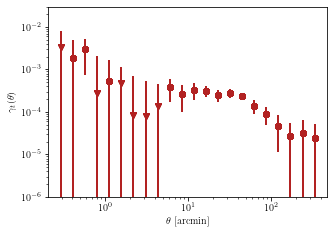

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


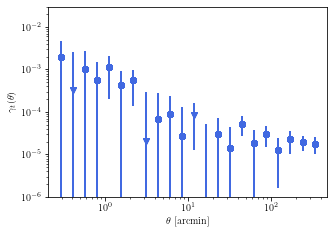

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


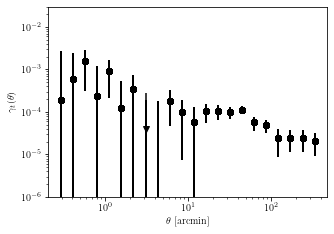

In [169]:
plot_tangential_shear(theta_red, xi_red, err_jk_red, "firebrick", "Red")
plot_tangential_shear(theta_blue, xi_blue, err_jk_blue, "royalblue", "Blue")
plot_tangential_shear(theta, xi, err_jk, "black", "Total")

We calculate the $\chi^2_\mathrm{null}$ and the signal-to-noise for the total sample, red LSBG sample, and blue LSBG sample. Note that the blue LSBG sample does not produce a signal.

In [170]:
chi2_total = chi2_null(cov=cov, measurements=xi, n=n, m=m)
sn_total = sn(n=n, m=m, dof=dof, cov=cov, measurements=xi)
print(chi2_total, sn_total)

50.09624659222689 5.30058926839525


In [171]:
chi2_red = chi2_null(cov=cov_red, measurements=xi_red, n=n, m=m)
sn_red = sn(n=n, m=m, dof=dof, cov=cov_red, measurements=xi_red)
print(chi2_red, sn_red)

66.42409585545164 6.665140347768503


In [172]:
chi2_blue = chi2_null(cov=cov_blue, measurements=xi_blue, n=n, m=m)
sn_blue = sn(n=n, m=m, dof=dof, cov=cov_blue, measurements=xi_blue)
print(chi2_blue, sn_blue)

26.69542735014794 2.1668934791881074


## Systematics Evaluations

We call the function to plot the shear of the $\gamma_{\times}$ term and calculate the $\chi^2$. Note that we do not produce a measurable signal for the $\gamma_{\times}$ term, confirming our expectations, and we include an offset in $\theta$ to improve the visibility of the measurements. 

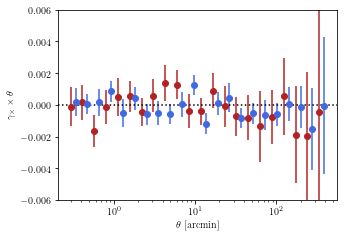

In [173]:
plot_cross_term(theta=theta, cross_term_arr=cross_term_arr, cross_term_cov_arr=cross_term_cov_arr)

In [140]:
chi2_cross_term = chi2_null(cov=cross_term_cov, measurements=cross_term, n=n, m=m)
sn_cross_term = sn(n=n, m=m, dof=dof, cov=cross_term_cov, measurements=cross_term)
print(chi2_cross_term, sn_cross_term)

13.579812600693838 nan


/var/folders/k7/xk17x8f56cs0qfbgc1vnw58r0000gn/T/ipykernel_6865/938614752.py:13: RuntimeWarning: invalid value encountered in sqrt
  sn = np.sqrt(chi2-dof)


In [141]:
chi2_cross_term_red = chi2_null(cov=cross_term_cov_red, measurements=cross_term_red, n=n, m=m)
sn_cross_term_red = sn(n=n, m=m, dof=dof, cov=cross_term_cov_red, measurements=cross_term_red)
print(chi2_cross_term_red, sn_cross_term_red)

14.842226019461867 nan


/var/folders/k7/xk17x8f56cs0qfbgc1vnw58r0000gn/T/ipykernel_6865/938614752.py:13: RuntimeWarning: invalid value encountered in sqrt
  sn = np.sqrt(chi2-dof)


In [142]:
chi2_cross_term_blue = chi2_null(cov=cross_term_cov_blue, measurements=cross_term_blue, n=n, m=m)
sn_cross_term_blue = sn(n=n, m=m, dof=dof, cov=cross_term_cov_blue, measurements=cross_term_blue)
print(chi2_cross_term_blue, sn_cross_term_blue)

15.956030595228226 nan


/var/folders/k7/xk17x8f56cs0qfbgc1vnw58r0000gn/T/ipykernel_6865/938614752.py:13: RuntimeWarning: invalid value encountered in sqrt
  sn = np.sqrt(chi2-dof)


We call the function to plot the shear of the randoms sample and calculate the $\chi^2$. Note that we do not produce a measurable signal for the randoms term, confirming our expectations.

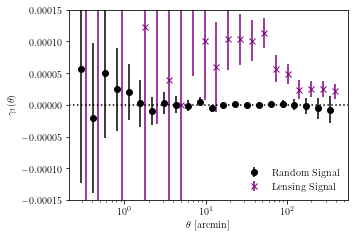

In [143]:
plot_ran_shear(theta_randoms=theta_randoms, xi_randoms=xi_randoms, err_jk_randoms=err_jk_randoms)

In [144]:
chi2_randoms = chi2_null(cov=randoms_cov, measurements=xi_randoms, n=n, m=m)
sn_randoms = sn(n=n, m=m, dof=dof, cov=randoms_cov, measurements=xi_randoms)
print(chi2_randoms, sn_randoms)

3.2121370063944616 nan


/var/folders/k7/xk17x8f56cs0qfbgc1vnw58r0000gn/T/ipykernel_6865/938614752.py:13: RuntimeWarning: invalid value encountered in sqrt
  sn = np.sqrt(chi2-dof)


We plot the comparison between the shape noise and jackknife covariance diagonals for the red, blue, and total sample of galaxies over angular scales. The shape noise represents the combined uncertainty associated with the intrinsic ellipticity of the source galaxies and the shot noise from the Poisson statistic. Note that the jackknife covariance dominates at all scales. The color of each line represents the sample, with blue associated with blue LSBGs, red with red LSBGs, and black with the total sample. 

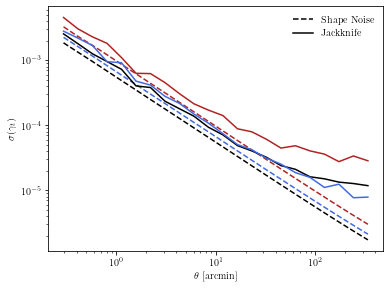

In [145]:
noise_diag(theta_arr=theta_arr, error_arr=error_arr, err_jk_arr=err_jk_arr, color_arr=color_arr)

We plot the correlation matrices for the jackknife covariance of the red LSBGs and blue LSBGs. The *x* and *y* axes correspond to the angular bins of the tangential shear measurements. At larger scales (bins>14), the correlation between bins grows stronger.

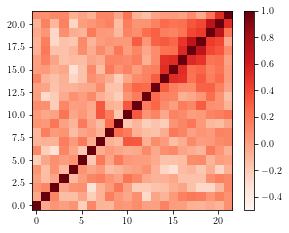

In [96]:
plot_cov(cov=cov_red, size=6, colormap='Reds')

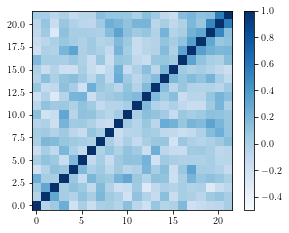

In [97]:
plot_cov(cov=cov_blue, size=6, colormap='Blues')

## Boost Factor Evaluation

We call the functions to plot the boost factors for the red and blue LSBG samples and calculate the $\chi^2$. The errorbars come from the jackknife covariance. The boost factor measurements are highly correlated and consistent with 1 for both red and blue galaxies. The increased size of the red galaxy errorbars stems from the higher spatial variation between the red galaxy positions in the DES footprint and the resulting increased covariance measurements. 

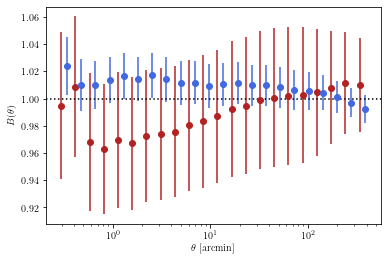

In [65]:
boost_plot(theta_boost_arr=theta_boost_arr, boost_factor_arr=boost_factor_arr, boost_factor_cov_arr=boost_factor_cov_arr, color_arr_boost=color_arr_boost)


## Alternative Blue Measurements Cut

We include tangential shear measurements a "bluer" sample of the blue LSBGs, with a cutoff of $g-i<0.4$, for further analysis

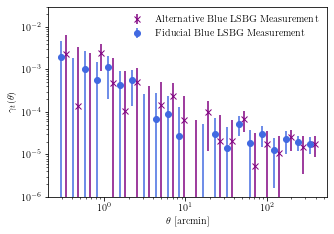

In [72]:
fig = plt.figure(figsize=(5,3.5))
plt.errorbar(theta_blue_alt*1.15, xi_blue_alt, err_jk_blue_alt, fmt="x", color='purple', label='Alternative Blue LSBG Measurement')
plt.errorbar(theta_blue, xi_blue, err_jk_blue, fmt="o", color='royalblue', label='Fiducial Blue LSBG Measurement')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$\gamma_t(\\theta)$")
plt.ylim(10**(-6),  3*10**(-2))
plt.legend(frameon=False)
plt.show()

## Summary

In this notebook you've learned how to: 
* Plot the tangential shear measurements for the red, blue, and total LSBG sample
* Analyze the $\gamma_\times$ term and the shear of the randoms sample
* Compare the shape noise to the jackknife covariance
* Examine the boost factors
* Compare the additional color-cut blue LSBG measurements to the fiducial sample